# Selecting appropriate users for training the models

**This notebook provides code to select user ids that are more suitable for training models and submitting predictions** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv")
df_train = df_train.reindex(columns=['user_id', 'date', 'id1', 'id2', 'id3'])

## The code to select suitable users

As will be elaborated further below, more than 75% of the users in the dataset have at most 10 impressions. Therefore, a large chunk of the users has little informational value and there is a low chance that these will be active during the next 7 days. Hence, it is best to remove them from the dataset and only use those users that have more interactions with the website.

The code below creates a dataframe that compiles the following information for every user:
- Number of impressions: How often is the user present in the dataset
- Number of active days: On how many different days was the user active?
- Number of active days within the last 21 days
- Number of active days within the last 7 days
- Number of different categories, subcategories, and products the user has looked at 

We assume that a user with high informational value has been active on several days, has looked at several different values and has been active both in the last 21 days and last 7 days. There is no hard rule for the cutoff values for the individual criteria, however, we provide guidelines further below.

The users that satisfy the imposed criteria can be selected using boolean indexing and can then be used to create a new dataframe, the code for this is provided below

In [3]:
%%time
# This code snippet creates a dataframe that records the above mentioned information for each user
def create_user_information(df_train, today=54):
    df_last_21 = df_train[df_train['date'] > today - 21]
    df_last_7 = df_train[df_train['date'] > today - 7]

    gb_last_21 = df_last_21.groupby(['user_id'])
    gb_last_7 = df_last_7.groupby(['user_id'])

    user_information = pd.DataFrame()
    # Impressions = Number of clicks in total
    user_information['impressions'] = df_train.groupby(['user_id'])['date'].count()

    # On how many different days has the user been active?
    # How many of these were in the last 21 days?
    # How many in the last 7 days?
    user_information['active_days'] = df_train.groupby(['user_id'])['date'].nunique()
    user_information = user_information.join(gb_last_21['date'].nunique(), how='outer', rsuffix = '21')
    user_information = user_information.join(gb_last_7['date'].nunique(), how='outer', rsuffix = '7')

    # How many different products have been looked at?
    # How many in the last 21 days?
    # id1
    user_information['unique_ct1'] = df_train.groupby(['user_id'])['id1'].nunique()
    # id2
    user_information['unique_ct2'] = df_train.groupby(['user_id'])['id2'].nunique()
    # id3
    user_information['unique_ct3'] = df_train.groupby(['user_id'])['id3'].nunique()

    # Some user_ids might have NA for the last 21 days columns
    user_information.fillna(value=0, inplace=True)
    user_information.columns = ['impressions',
                                'active_days',
                                'active_days_last_21',
                                'active_days_last_7',
                                'unique_ct1',
                                'unique_ct2',
                                'unique_ct3']
    return user_information

CPU times: user 11 µs, sys: 6 µs, total: 17 µs
Wall time: 30.8 µs


This is an example of how to select suitable user ids. The cutoff values are somewhat arbitray but we expect them to lead to a better dataset than the initial one.

In [4]:
%%time
user_information = create_user_information(df_train)
selected_user_ids = user_information[(user_information['active_days'] > 12)
                                   & (user_information['active_days_last_21'] >= 8)
                                   & (user_information['unique_ct3'] >= 4)
                                   & (user_information['active_days_last_7'] >= 3)].index

CPU times: user 1min 50s, sys: 10.4 s, total: 2min 1s
Wall time: 2min 6s


Select only the entries with suitable user_ids and write the new dataset to file.

In [6]:
%%time
df_reduced = df_train[df_train['user_id'].isin(selected_user_ids)]
df_reduced.to_csv("reduced_training_data.csv", index=False, header=True)

CPU times: user 1min, sys: 4.57 s, total: 1min 4s
Wall time: 1min 8s


## Explanation and data analysis

To motivate the selection of users, we answer the following questions:
- What are the average numbers of impressions, active days, and product categories visited for the users? What do the distribution look like?
- Is there any periodicity in the data, i.e. does the number of impressions depend on the day of the week?
- Are bots in the dataset that should be removed?

### What are the average numbers of impressions, active days, and product categories visited for the users? What do the distribution look like?

Some observations (details below):
- The median of the number of impressions is 9, but the median is 43.
- People are on average on 8 days active, the median is 5.
- The mean number of products looked at is 23, but the median is only 6.
- The distribution of the impressions seems to follow a power law.
As the distribution seem to follow a power law, it makes sense to concentrate only on a comparatively small fraction of users that generates the majority of all impressions, active days etc.

In [7]:
user_information.describe()

,impressions,active_days,active_days_last_21,active_days_last_7,unique_ct1,unique_ct2,unique_ct3
count,1.079572e+06,1.079572e+06,1.079572e+06,1.079572e+06,1.079572e+06,1.079572e+06,1.079572e+06
mean,4.353283e+01,7.997622e+00,3.395455e+00,1.096329e+00,4.858678e+00,1.116100e+01,2.363637e+01
std,1.558430e+02,8.847903e+00,3.691735e+00,1.370320e+00,3.903999e+00,1.693499e+01,5.797178e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
50%,9.000000e+00,5.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
75%,2.800000e+01,1.000000e+01,4.000000e+00,2.000000e+00,7.000000e+00,1.200000e+01,1.600000e+01
max,1.904100e+04,5.400000e+01,2.100000e+01,7.000000e+00,1.600000e+01,1.180000e+02,7.690000e+02


For comparison, the information for our selected users. For these, mean and median tend to be much closer together.

In [8]:
selected_user_information = create_user_information(df_reduced)

In [9]:
selected_user_information.describe()

,impressions,active_days,active_days_last_21,active_days_last_7,unique_ct1,unique_ct2,unique_ct3
count,75101.000000,75101.000000,75101.000000,75101.000000,75101.000000,75101.000000,75101.000000
mean,194.046018,28.928589,12.759058,4.249744,9.746994,30.359196,75.505639
std,344.848224,10.329837,3.502031,1.090339,3.625651,23.855896,96.992269
min,13.000000,13.000000,8.000000,3.000000,1.000000,1.000000,4.000000
25%,48.000000,21.000000,10.000000,3.000000,7.000000,12.000000,17.000000
50%,84.000000,28.000000,12.000000,4.000000,10.000000,24.000000,38.000000
75%,194.000000,36.000000,15.000000,5.000000,13.000000,41.000000,85.000000
max,12843.000000,54.000000,21.000000,7.000000,16.000000,118.000000,750.000000


#### Distributions of the different categories:

Text(0.5,0,'Number of products visited')

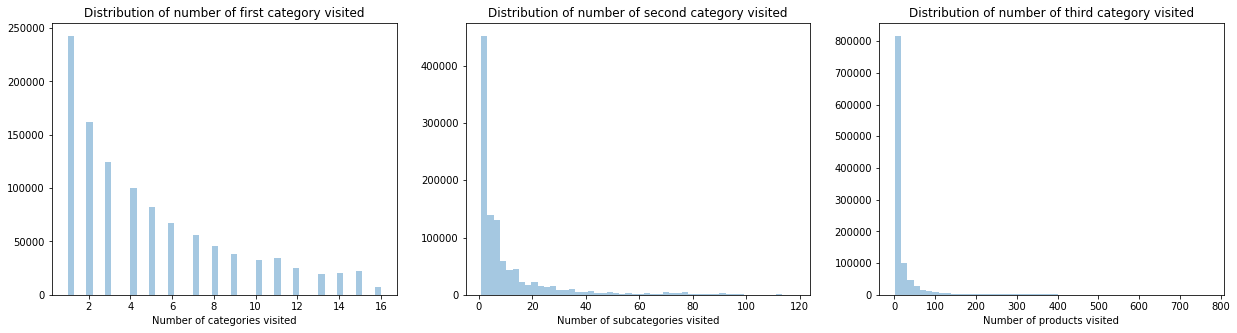

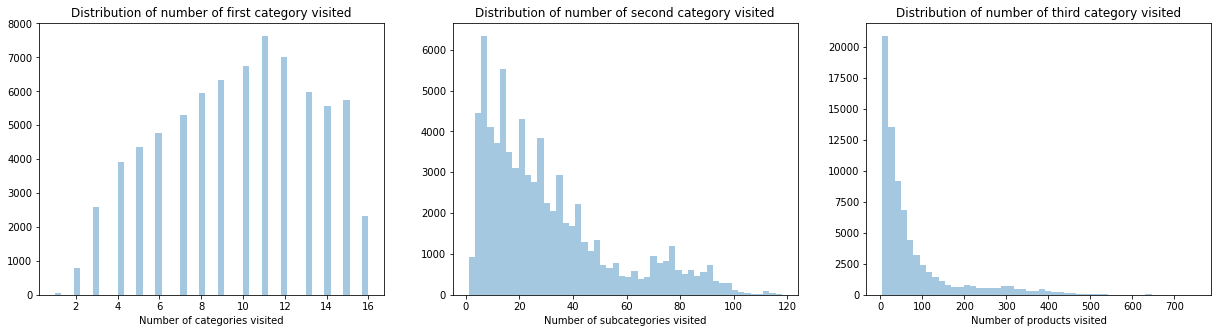

In [10]:
plt.figure(figsize=(21,5))
plt.subplot(1,3,1)
sns.distplot(user_information['unique_ct1'], kde=False)
plt.title('Distribution of number of first category visited')
plt.xlabel('Number of categories visited')
plt.subplot(1,3,2)
sns.distplot(user_information['unique_ct2'], kde=False)
plt.title('Distribution of number of second category visited')
plt.xlabel('Number of subcategories visited')
plt.subplot(1,3,3)
sns.distplot(user_information['unique_ct3'], kde=False)
plt.title('Distribution of number of third category visited')
plt.xlabel('Number of products visited')

# For comparison, the information for the reduced dataset
plt.figure(figsize=(21,5))
plt.subplot(1,3,1)
sns.distplot(selected_user_information['unique_ct1'], kde=False)
plt.title('Distribution of number of first category visited')
plt.xlabel('Number of categories visited')
plt.subplot(1,3,2)
sns.distplot(selected_user_information['unique_ct2'], kde=False)
plt.title('Distribution of number of second category visited')
plt.xlabel('Number of subcategories visited')
plt.subplot(1,3,3)
sns.distplot(selected_user_information['unique_ct3'], kde=False)
plt.title('Distribution of number of third category visited')
plt.xlabel('Number of products visited')

#### Distribution of impressions and active days

Text(0.5,0,'Number of active days')

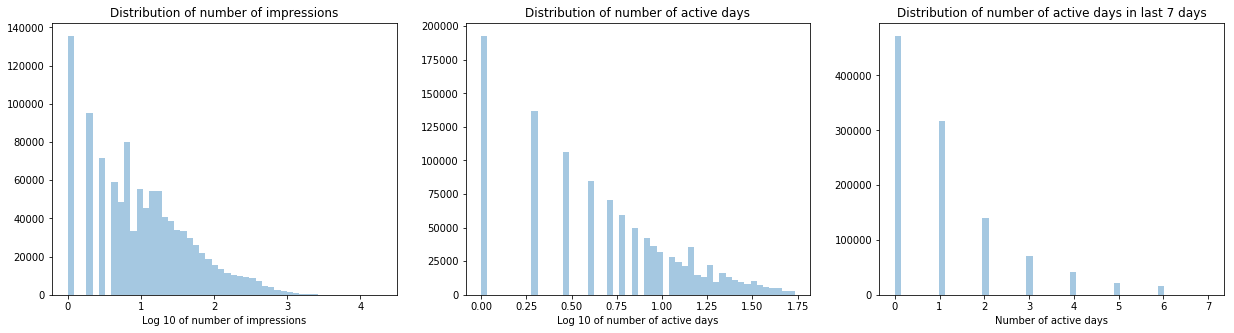

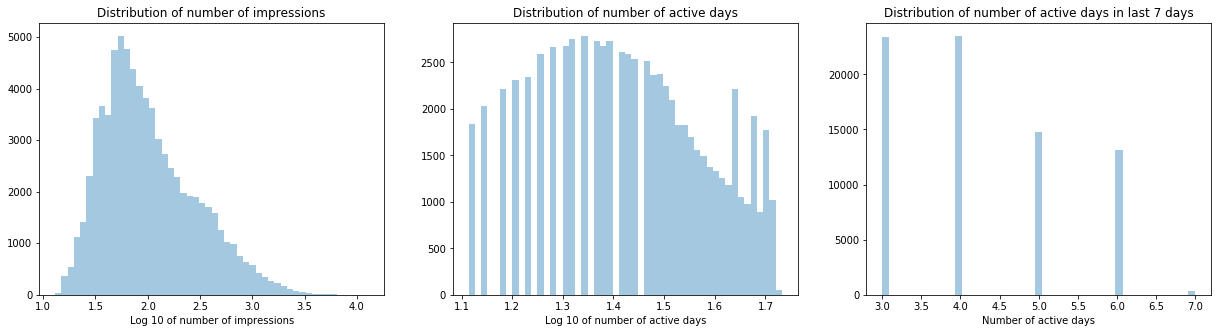

In [11]:
plt.figure(figsize=(21,5))
plt.subplot(1,3,1)
sns.distplot(np.log10(user_information['impressions']), kde=False)
plt.title('Distribution of number of impressions')
plt.xlabel('Log 10 of number of impressions')
plt.subplot(1,3,2)
sns.distplot(np.log10(user_information['active_days']), kde=False)
plt.title('Distribution of number of active days')
plt.xlabel('Log 10 of number of active days')
plt.subplot(1,3,3)
sns.distplot(user_information['active_days_last_7'], kde=False)
plt.title('Distribution of number of active days in last 7 days')
plt.xlabel('Number of active days')

# For comparison, the information for the reduced dataset
plt.figure(figsize=(21,5))
plt.subplot(1,3,1)
sns.distplot(np.log10(selected_user_information['impressions']), kde=False)
plt.title('Distribution of number of impressions')
plt.xlabel('Log 10 of number of impressions')
plt.subplot(1,3,2)
sns.distplot(np.log10(selected_user_information['active_days']), kde=False)
plt.title('Distribution of number of active days')
plt.xlabel('Log 10 of number of active days')
plt.subplot(1,3,3)
sns.distplot(selected_user_information['active_days_last_7'], kde=False)
plt.title('Distribution of number of active days in last 7 days')
plt.xlabel('Number of active days')

### Is there any periodicity in the data, i.e. does the number of impressions depend on the day of the week?
We find that there seems to be a variation of the number of unique users with the workday. More interestingly, we also find a large decline in the number of impressions in the second half of the time period.

In [12]:
%%time
# Determining the number of impressions per day
number_of_impressions_per_day = np.zeros(54)
number_of_unique_visitors_per_day = np.zeros(54)
for d in range(1, 55):
    tmp = df_train[df_train['date'] == d]['user_id']
    number_of_impressions_per_day[d-1] = tmp.size
    number_of_unique_visitors_per_day[d-1] = tmp.unique().size

CPU times: user 3.99 s, sys: 1.26 s, total: 5.25 s
Wall time: 5.27 s


In [13]:
daily_average_users, daily_average_impressions, day_count = np.zeros(7), np.zeros(7), np.zeros(7)
for d in range(0, 54):
    daily_average_users[d % 7] += number_of_unique_visitors_per_day[d]
    daily_average_impressions[d % 7] += number_of_impressions_per_day[d]
    day_count[d % 7] += 1
    
daily_average_users = np.divide(daily_average_users, day_count)
daily_average_impressions = np.divide(daily_average_impressions, day_count)

Text(0,0.5,'Average number of impressions')

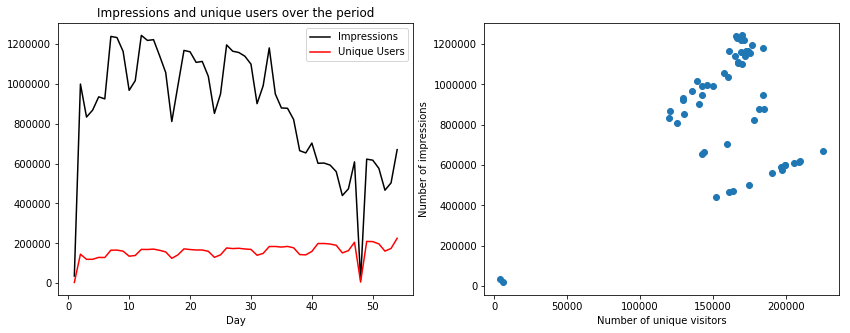

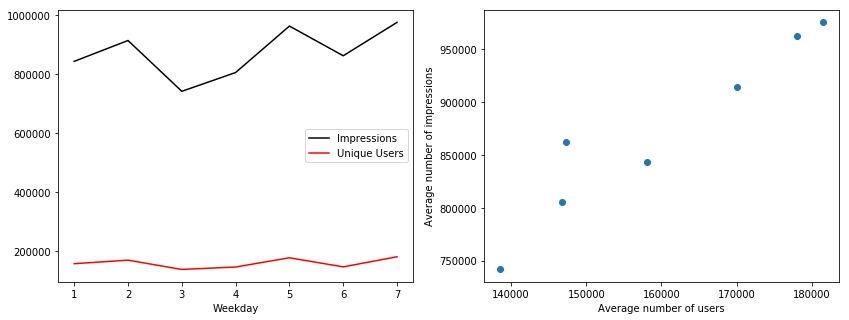

In [14]:
plt.figure(figsize=(14, 5))
# Plotting the time series
plt.subplot(1, 2, 1)
plt.plot(range(1, 55), number_of_impressions_per_day, 'k')
plt.plot(range(1, 55), number_of_unique_visitors_per_day, 'r')
plt.legend(['Impressions', 'Unique Users'])
plt.xlabel('Day')
plt.title('Impressions and unique users over the period')

# Evaluating the relationship between unique visitors per day
# and number of impressions
plt.subplot(1, 2, 2)
plt.scatter(number_of_unique_visitors_per_day, number_of_impressions_per_day)
plt.xlabel('Number of unique visitors')
plt.ylabel('Number of impressions')

## Plotting the average results
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,8), daily_average_impressions, 'k')
plt.plot(range(1,8), daily_average_users, 'r')
plt.legend(['Impressions', 'Unique Users'])
plt.xlabel('Weekday')

plt.subplot(1, 2, 2)
plt.scatter(daily_average_users, daily_average_impressions)
plt.xlabel('Average number of users')
plt.ylabel('Average number of impressions')


### Are bots in the dataset that should be removed?
It is not clear yet how to find bots and whether they are detrimental to the predictions...
Also, there seems to be some funky stuff going on with id3 = 610.

In [15]:
user_information[user_information['active_days'] > 50].sort_values(by='impressions', ascending=False).head(15)

,impressions,active_days,active_days_last_21,active_days_last_7,unique_ct1,unique_ct2,unique_ct3
user_id,,,,,,,
859034,7656,51,19.0,5.0,16,110,611
158593,6694,51,19.0,5.0,16,114,638
1148263,6363,52,20.0,6.0,15,105,497
183970,5715,51,19.0,6.0,16,100,515
137082,5669,53,21.0,7.0,14,70,178
552664,5593,52,20.0,6.0,16,108,427
358572,5179,52,20.0,6.0,16,102,454
1072721,4927,52,20.0,6.0,13,51,127
800344,4685,52,20.0,6.0,15,78,325


In [16]:
user_information[user_information['impressions'] > 10000]

,impressions,active_days,active_days_last_21,active_days_last_7,unique_ct1,unique_ct2,unique_ct3
user_id,,,,,,,
8795,10066,29,8.0,2.0,16,113,559
33561,10388,23,2.0,0.0,15,110,548
125350,13304,22,3.0,0.0,16,114,641
137376,12031,22,2.0,1.0,16,113,634
241117,19041,37,7.0,1.0,16,114,634
247312,12843,33,10.0,3.0,16,114,646
351837,17898,36,4.0,0.0,16,113,559
390572,10147,20,1.0,1.0,16,114,638
421418,10777,29,10.0,4.0,16,114,635
